In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# --- 1. Load and Merge Data ---

# Load data
# train_transaction = pd.read_csv('../input/train_transaction.csv')
# train_identity = pd.read_csv('../input/test_transaction.csv')
train_transaction = pd.read_csv('C:/Users/Matúš/Desktop/Marekova praca/Prediction-of-Fraud-transactions/input/train_transaction.csv')
train_identity = pd.read_csv('C:/Users/Matúš/Desktop/Marekova praca/Prediction-of-Fraud-transactions/input/train_identity.csv')

# Merge datasets
train_df = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

# Simple target definition
# X_check = train_df.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1)
# y_check = train_df['isFraud']

In [3]:
train_df = train_df.sort_values('TransactionDT')

train_df['uid'] = train_df['card1'].astype(str)+'_'+train_df['card2'].astype(str)+'_'+train_df['addr1'].astype(str)

# 2. Transaction Amount relative to User Average
# Does this user usually spend $10 but is now spending $1000?
train_df['uid_Amt_mean'] = train_df.groupby(['uid'])['TransactionAmt'].transform('mean')
train_df['uid_Amt_std'] = train_df.groupby(['uid'])['TransactionAmt'].transform('std')
train_df['Amt_to_mean_ratio'] = train_df['TransactionAmt'] / train_df['uid_Amt_mean']

# 3. Time Engineering
# Fraud often peaks at 3 AM or on weekends.
train_df['hour'] = (train_df['TransactionDT'] // 3600) % 24
train_df['day_of_week'] = (train_df['TransactionDT'] // (3600 * 24)) % 7

# 2. Calculate Cutoff Points
n_total = len(train_df)
idx_train_end = int(n_total * 0.70)      # End of first 70%
idx_val_end   = int(n_total * 0.85)      # End of next 15% (70+15=85)

In [4]:
# 3. Slice the Dataframe
# .iloc works by position [start : end]
train_set = train_df.iloc[ :idx_train_end]              # 0% to 70%
val_set   = train_df.iloc[idx_train_end : idx_val_end]  # 70% to 85%
test_set  = train_df.iloc[idx_val_end: ]                # 85% to 100%

In [5]:
cols_to_drop = ['isFraud', 'TransactionID', 'TransactionDT']

# TRAIN
X_train = train_set.drop(cols_to_drop, axis=1)
y_train = train_set['isFraud']

# VALIDATION
X_val = val_set.drop(cols_to_drop, axis=1)
y_val = val_set['isFraud']

# TEST (The Hold-out)
X_test = test_set.drop(cols_to_drop, axis=1)
y_test = test_set['isFraud']

In [6]:
missing_threshold = 0.80

missing_series = X_train.isnull().mean()
drop_cols = missing_series[missing_series > missing_threshold].index
print(f"Dropping {len(drop_cols)} columns with > {missing_threshold:.0%} missing values.")

X_train_clean = X_train.drop(columns=drop_cols)
X_val_clean   = X_val.drop(columns=drop_cols)
X_test_clean  = X_test.drop(columns=drop_cols)

Dropping 74 columns with > 80% missing values.


In [7]:
X_xgb = X_train_clean.copy()

print("Encoding categorical columns for XGBoost...")
for col in X_xgb.select_dtypes(include=['object']).columns:
    X_xgb[col] = X_xgb[col].astype('category').cat.codes

# 2. Configure & Train XGBoost
# We use 'hist' tree method because it's extremely fast
clf = XGBClassifier(
    n_estimators=100,       # 100 trees is enough for feature selection
    max_depth=10,           # Deep trees to find complex fraud patterns
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    missing=np.nan,         # Critical: Tells XGBoost to handle NaNs automatically
    n_jobs=-1,              # Use all CPU cores
    random_state=42,
    tree_method='hist'      # Fast training mode
)

print("Training XGBoost to find the most important features...")
clf.fit(X_xgb, y_train)

Encoding categorical columns for XGBoost...
Training XGBoost to find the most important features...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, ...)

--- Top 100 Features Selected ---
['V258', 'C1', 'C14', 'D2', 'card2', 'C13', 'uid_Amt_std', 'uid_Amt_mean', 'uid', 'addr1']


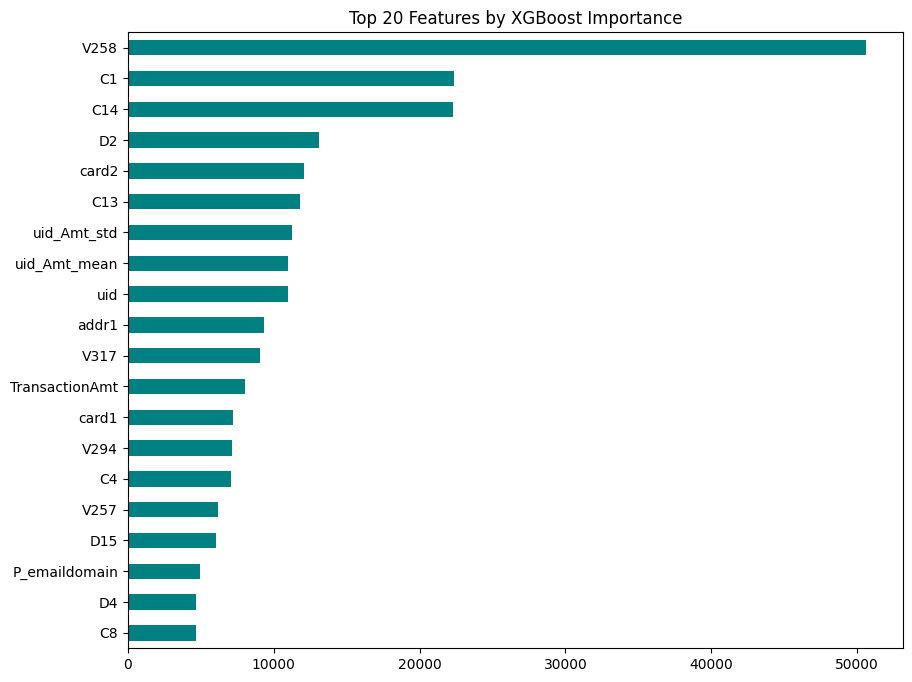

In [8]:
importances = pd.Series(clf.get_booster().get_score(importance_type='total_gain'))

# 2. Sort and Take Top 50
TOP_N = 100
best_features = importances.sort_values(ascending=False).head(TOP_N).index.tolist()

print(f"--- Top {TOP_N} Features Selected ---")
print(best_features[:10])  # Print top 10 to check

# 3. Visualize
plt.figure(figsize=(10, 8))
importances.sort_values(ascending=False).head(20).plot(kind='barh', color='teal')
plt.title('Top 20 Features by XGBoost Importance')
plt.gca().invert_yaxis() # Highest importance on top
plt.show()

In [9]:
FINAL_CAT_COLS = []
FINAL_NUM_COLS = []

print("classifying Top Features...")

for col in best_features:
    # A. Is it an Object (String) in the original cleaned data?
    if X_train_clean[col].dtype == 'object':
        FINAL_CAT_COLS.append(col)
        
    # B. Is it a Number but behaves like a Category? (Few unique values)
    # Example: 'card4' might be 1, 2, 3, 4. Treat as Category.
    elif X_train_clean[col].nunique() < 20:
        FINAL_CAT_COLS.append(col)
        
    # C. Otherwise, it is a Number (Amount, Time, Distance)
    else:
        FINAL_NUM_COLS.append(col)

print(f"--------------------------------")
print(f"Feature Split for Neural Network:")
print(f" - Categorical (Embeddings): {len(FINAL_CAT_COLS)}")
print(f" - Numerical (Scaled):       {len(FINAL_NUM_COLS)}")
print(f"--------------------------------")

manual_features = ['Amt_to_mean_ratio', 'hour', 'day_of_week']

for feat in manual_features:
    if feat not in best_features:
        best_features.append(feat)

if 'uid' in best_features:
    best_features.remove('uid')
    print("✅ Stĺpec 'uid' bol úspešne odstránený zo zoznamu čŕt.")

# Finalize the Datasets
# We now discard all other columns and keep only the winners
X_train_ready = X_train_clean[best_features].copy()
X_val_ready   = X_val_clean[best_features].copy()
X_test_ready  = X_test_clean[best_features].copy()

classifying Top Features...
--------------------------------
Feature Split for Neural Network:
 - Categorical (Embeddings): 30
 - Numerical (Scaled):       70
--------------------------------
✅ Stĺpec 'uid' bol úspešne odstránený zo zoznamu čŕt.


In [10]:
# 1. Setup the 3 datasets (Fresh copies)
# We use the 'ready' sets (Top 50 features) you created earlier
X_xgb_train = X_train_ready.copy()
X_xgb_val   = X_val_ready.copy()
X_xgb_test  = X_test_ready.copy()

FINAL_CAT_COLS = [col for col in FINAL_CAT_COLS if col in best_features]
print(f"Zostávajúce kategorické stĺpce: {FINAL_CAT_COLS}")

print("Preparing data for XGBoost...")

# 2. Encode Categoricals (Text -> Number)
# XGBoost can't read "Visa", so we turn it into numbers.
# We do NOT need to scale numbers or fill missing values.
for col in FINAL_CAT_COLS:
    # Combine to ensure same encoding across all sets
    temp_all = pd.concat([X_xgb_train[col], X_xgb_val[col], X_xgb_test[col]])
    
    # Fit the encoder
    le = LabelEncoder()
    le.fit(temp_all.astype(str))
    
    # Transform each set
    X_xgb_train[col] = le.transform(X_xgb_train[col].astype(str))
    X_xgb_val[col]   = le.transform(X_xgb_val[col].astype(str))
    X_xgb_test[col]  = le.transform(X_xgb_test[col].astype(str))

print("✅ Data Ready. (Notice: No scaling or mean-filling needed!)")

Zostávajúce kategorické stĺpce: ['P_emaildomain', 'R_emaildomain', 'card6', 'V189', 'M5', 'V62', 'M4', 'V91', 'id_31', 'V70', 'ProductCD', 'DeviceInfo', 'M6', 'V12', 'V83', 'V54', 'day_of_week', 'V82', 'card4', 'DeviceType', 'V53', 'id_12', 'V61', 'V67', 'V66', 'V20', 'V76', 'V30', 'V13']
Preparing data for XGBoost...
✅ Data Ready. (Notice: No scaling or mean-filling needed!)


In [11]:
# 1. Calculate Class Weight (For Imbalance)
# XGBoost uses 'scale_pos_weight' = count(neg) / count(pos)
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
print(f"Fraud Imbalance Ratio: {ratio:.2f}")

# 2. Build the Model
clf = XGBClassifier(
    n_estimators=2000,        # Max epochs (high, because we stop early)
    learning_rate=0.02,       # Slow & careful learning
    max_depth=6,             # Deep trees for complex fraud patterns
    subsample=0.8,            # Use 80% of rows per tree
    colsample_bytree=0.8,     # Use 80% of columns per tree
    scale_pos_weight=ratio,   # Handle the imbalance
    missing=np.nan,           # Handle missing values automatically
    eval_metric='auc',        # Optimize for AUC
    tree_method='hist',       # Fast mode
    n_jobs=-1,
    random_state=42,
    reg_alpha=10,
    reg_lambda=10,
    min_child_weight=10,
    early_stopping_rounds=50 # Stop if validation score doesn't improve for 50 rounds
)

# 3. Train with Early Stopping
print("\nStarting XGBoost Training...")
clf.fit(
    X_xgb_train, y_train,
    # This is the "Validation" step
    eval_set=[(X_xgb_train, y_train), (X_xgb_val, y_val)],
    verbose=50                # Print progress every 50 rounds
)

Fraud Imbalance Ratio: 27.43

Starting XGBoost Training...
[0]	validation_0-auc:0.85388	validation_1-auc:0.82178
[50]	validation_0-auc:0.88735	validation_1-auc:0.86483
[100]	validation_0-auc:0.89801	validation_1-auc:0.87469
[150]	validation_0-auc:0.90699	validation_1-auc:0.88317
[200]	validation_0-auc:0.91429	validation_1-auc:0.88887
[250]	validation_0-auc:0.92265	validation_1-auc:0.89445
[300]	validation_0-auc:0.92986	validation_1-auc:0.89928
[350]	validation_0-auc:0.93545	validation_1-auc:0.90282
[400]	validation_0-auc:0.94029	validation_1-auc:0.90555
[450]	validation_0-auc:0.94433	validation_1-auc:0.90756
[500]	validation_0-auc:0.94764	validation_1-auc:0.90881
[550]	validation_0-auc:0.95096	validation_1-auc:0.91053
[600]	validation_0-auc:0.95368	validation_1-auc:0.91117
[650]	validation_0-auc:0.95622	validation_1-auc:0.91187
[700]	validation_0-auc:0.95867	validation_1-auc:0.91285
[750]	validation_0-auc:0.96107	validation_1-auc:0.91379
[800]	validation_0-auc:0.96342	validation_1-auc:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.02, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=2000,
              n_jobs=-1, num_parallel_tree=None, ...)

In [12]:
from sklearn.metrics import roc_auc_score

print("------------------------------------------------")
print("Evaluating XGBoost on TEST Set...")

# 1. Predict (Probabilities)
xgb_preds = clf.predict_proba(X_xgb_test)[:, 1]

# 2. Score
xgb_auc = roc_auc_score(y_test, xgb_preds)

print(f"🏆 XGBoost FINAL TEST ROC-AUC: {xgb_auc:.5f}")
print("------------------------------------------------")

------------------------------------------------
Evaluating XGBoost on TEST Set...
🏆 XGBoost FINAL TEST ROC-AUC: 0.90456
------------------------------------------------


=== TRAINING PERFORMANCE ===
              precision    recall  f1-score   support

   Legit (0)       1.00      0.94      0.97    398840
   Fraud (1)       0.37      0.91      0.52     14538

    accuracy                           0.94    413378
   macro avg       0.68      0.93      0.75    413378
weighted avg       0.97      0.94      0.95    413378



=== TEST PERFORMANCE ===
              precision    recall  f1-score   support

   Legit (0)       0.99      0.93      0.96     85498
   Fraud (1)       0.26      0.66      0.38      3083

    accuracy                           0.92     88581
   macro avg       0.62      0.80      0.67     88581
weighted avg       0.96      0.92      0.94     88581



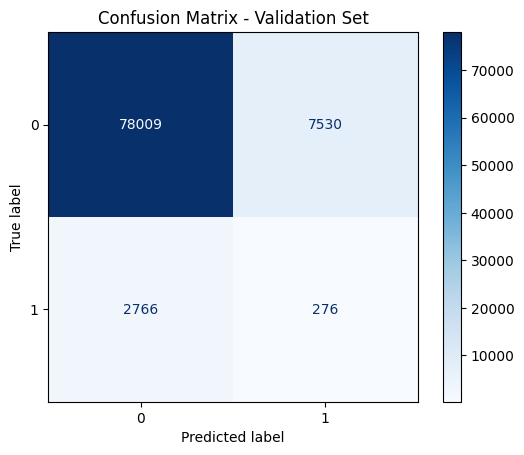

In [13]:
# 1. Get hard predictions (0 or 1) for both sets
y_train_pred = clf.predict(X_xgb_train)
y_test_pred = clf.predict(X_xgb_test)

# 2. Print Training Performance
print("=== TRAINING PERFORMANCE ===")
print(classification_report(y_train, y_train_pred, target_names=['Legit (0)', 'Fraud (1)']))

print("\n" + "="*30 + "\n")

# 3. Print Test Performance (This is what matters!)
print("=== TEST PERFORMANCE ===")
print(classification_report(y_test, y_test_pred, target_names=['Legit (0)', 'Fraud (1)']))

cm = confusion_matrix(y_val, y_test_pred)

# 3. Create the display
# 'clf.classes_' will automatically pull [0, 1] from your XGBoost model
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

# 4. Plot with a nice color map
disp.plot(cmap='Blues', values_format='d') # 'd' keeps numbers as integers, not scientific notation
plt.title('Confusion Matrix - Validation Set')
plt.show()

In [ ]:
# Convert probabilities to hard 0/1 predictions using the standard 0.5 threshold
y_pred_hard = (xgb_preds > 0.5).astype(int)

# Generate the confusion matrix
tn_x, fp_x, fn_x, tp_x = confusion_matrix(y_test, y_pred_hard).ravel()

# 2. Výpočet úspešnosti záchytu (Recall)
recall_xgb = (tp_x / (tp_x + fn_x)) * 100

print(f"--- XGBOOST PERFORMANCE ---")
print(f"Total Fraud in Test Set: {tp_x + fn_x}")
print(f"Correctly Caught (True Positives): {tp_x}")
print(f"Falsely marked as 'Unfraud' (False Negatives): {fn_x}")
print(f"Falsely marked as 'Fraud' (False Positives): {fp_x}")
print(f"---------------------------------")
print(f"XGBoost Fraud Capture Rate: {recall_xgb:.2f}%")

Total Fraud in Test Set: 3083
Correctly Caught (True Positives): 2046
Falsely marked as 'Unfraud' (False Negatives): 1037
Falsely marked as 'Fraud' (False Positives): 5760


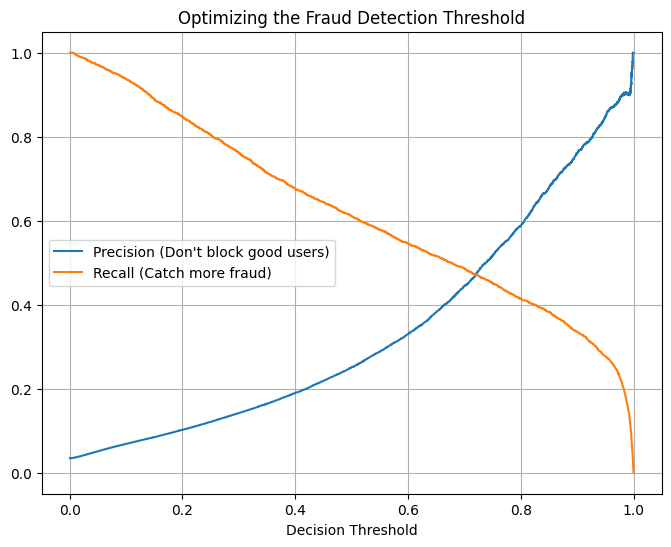

In [26]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# 1. Get probabilities for the Fraud class
y_scores = clf.predict_proba(X_test_ready)[:, 1]

# 2. Calculate Precision and Recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# 3. Plot the Trade-off
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precision (Don't block good users)")
plt.plot(thresholds, recall[:-1], label="Recall (Catch more fraud)")
plt.xlabel("Decision Threshold")
plt.title("Optimizing the Fraud Detection Threshold")
plt.legend()
plt.grid(True)
plt.show()

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


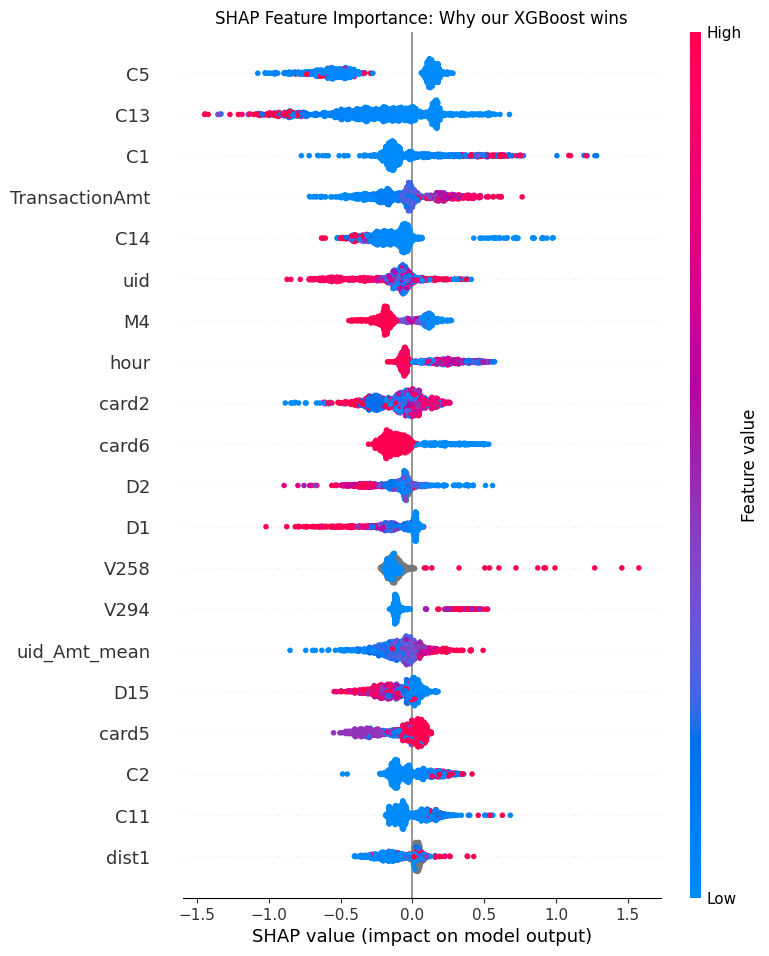

In [19]:
%pip install shap
import shap

explainer = shap.TreeExplainer(clf)

# 2. Calculate SHAP values for your test set
# We use a sample of 1000 rows so it finishes quickly
X_sample = X_xgb_test.iloc[:1000]
shap_values = explainer.shap_values(X_sample)

# 3. Create the Summary Plot for your Word Doc
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title("SHAP Feature Importance: Why our XGBoost wins")
plt.savefig("xgb_shap_analysis.png", bbox_inches='tight', dpi=300)
plt.show()

In [21]:
# List of columns causing the error from your log
error_cols = [
    'uid', 'P_emaildomain', 'R_emaildomain', 'card6', 'M5', 'M4', 
    'id_31', 'ProductCD', 'DeviceInfo', 'M6', 'card4', 'DeviceType', 'id_12'
]

# Convert these columns to 'category' dtype for all sets
for df in [X_train_ready, X_val_ready, X_test_ready]:
    for col in error_cols:
        if col in df.columns:
            df[col] = df[col].astype('category')

print("✅ Categorical columns converted to 'category' dtype.")

✅ Categorical columns converted to 'category' dtype.


In [22]:
# 1. Generate predictions for the test set
test_probs = clf.predict_proba(X_test_ready)[:, 1]

# 2. Create an analysis dataframe
fn_analysis = X_test_ready.copy()
fn_analysis['actual'] = y_test.values
fn_analysis['probability'] = test_probs

# 3. Filter for False Negatives (Actual Fraud, but Model said < 10% chance)
false_negatives = fn_analysis[(fn_analysis['actual'] == 1) & (fn_analysis['probability'] < 0.1)]

print(f"Number of False Negatives (Missed Fraud): {len(false_negatives)}")

# 4. Statistical Observation for your report
print("\nComparing False Negatives to General Fraud:")
stats = pd.DataFrame({
    'Missed Fraud (FN)': false_negatives.mean(numeric_only=True),
    'Total Fraud': fn_analysis[fn_analysis['actual'] == 1].mean(numeric_only=True)
})
print(stats.loc[['TransactionAmt', 'hour', 'dist1']])

Number of False Negatives (Missed Fraud): 194

Comparing False Negatives to General Fraud:
                Missed Fraud (FN)  Total Fraud
TransactionAmt         109.595557   152.321934
hour                    15.046392    13.571521
dist1                  100.409091   166.799728


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
AFTER TUNING PARAMS 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [21]:
# 1. Define the Search Space
param_grid = {
    'max_depth': [6, 8, 10, 12],
    'learning_rate': [0.01, 0.02, 0.05],
    'min_child_weight': [1, 5, 10, 20],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'n_estimators': [1000] # We use a fixed high number and early stopping
}

# 2. Setup the Search
xgb_search = RandomizedSearchCV(
    XGBClassifier(tree_method='hist', device="cuda"), # Use GPU if available
    param_distributions=param_grid,
    n_iter=15,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=42
)

# 3. Fit (This will take a few minutes)
xgb_search.fit(X_xgb_train, y_train)

print(f"Best XGB Params: {xgb_search.best_params_}")

Fitting 3 folds for each of 15 candidates, totalling 45 fits


c:\Users\Matúš\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:729: UserWarning: [01:05:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Best XGB Params: {'subsample': 0.7, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


In [24]:
# 1. Pull the best parameters (or use these optimized defaults if you haven't finished the search)
params = xgb_search.best_params_ 

# 1. Define the model with the metrics and stopping rounds INSIDE the constructor
final_xgb = XGBClassifier(
    n_estimators=5000,           
    learning_rate=params.get('learning_rate', 0.02),
    max_depth=params.get('max_depth', 10),
    min_child_weight=params.get('min_child_weight', 10),
    subsample=params.get('subsample', 0.8),
    colsample_bytree=params.get('colsample_bytree', 0.8),
    scale_pos_weight=27.43,      
    tree_method='hist',          
    random_state=42,
    n_jobs=-1,
    # --- MOVE THESE HERE ---
    eval_metric='auc',
    early_stopping_rounds=50
)

# 2. Now the .fit() call is clean and standard
print("🚀 Training Final XGBoost...")
final_xgb.fit(
    X_xgb_train, y_train,
    eval_set=[(X_xgb_val, y_val)],
    verbose=100
)

🚀 Training Final XGBoost...
[0]	validation_0-auc:0.79228
[100]	validation_0-auc:0.89778
[200]	validation_0-auc:0.90563
[300]	validation_0-auc:0.91023
[400]	validation_0-auc:0.91331
[500]	validation_0-auc:0.91483
[600]	validation_0-auc:0.91568
[700]	validation_0-auc:0.91587
[800]	validation_0-auc:0.91598
[815]	validation_0-auc:0.91591


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=5000,
              n_jobs=-1, num_parallel_tree=None, ...)

In [26]:
print("------------------------------------------------")
print("Evaluating XGBoost on TEST Set...")

# 1. Predict (Probabilities)
xgb_preds = final_xgb.predict_proba(X_xgb_test)[:, 1]

# 2. Score
xgb_auc = roc_auc_score(y_test, xgb_preds)

print(f"🏆 XGBoost FINAL TEST ROC-AUC: {xgb_auc:.5f}")
print("------------------------------------------------")

------------------------------------------------
Evaluating XGBoost on TEST Set...
🏆 XGBoost FINAL TEST ROC-AUC: 0.88960
------------------------------------------------
